<a href="https://colab.research.google.com/github/Johan14k/Practicas/blob/main/Ringa_Tech_Clasificador_de_perros_y_gatos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

#Correccion temporal (22/mayo/2022)
#Tensorflow datasets tiene error al descargar el set de perros y gatos y lo solucionaron
#el 16 de mayo pero sigue fallando en los colabs. Entonces se agrega esta linea adicional
#Mas detalle aqui: https://github.com/tensorflow/datasets/issues/3918
setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

#Descargar el set de datos de perros y gatos
datos, metadatos = tfds.load('cats_vs_dogs', as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.8CCDNJ_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


In [2]:
#Imprimir los metadatos para revisarlos
metadatos

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.1',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_dir=PosixGPath('/tmp/tmp9e30ik3dtfds'),
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=1.04 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=16>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, Jared},
  

,image,label
0,,1 (dog)
1,,1 (dog)
2,,1 (dog)
3,,0 (cat)
4,,1 (dog)

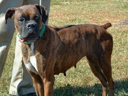
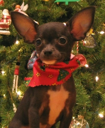
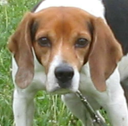
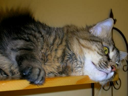
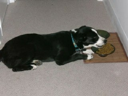

In [3]:
#Una forma de mostrar 5 ejemplos del set
tfds.as_dataframe(datos['train'].take(5), metadatos)

In [ ]:
#Otra forma de mostrar ejemplos del set
tfds.show_examples(datos['train'], metadatos)

In [ ]:
#Manipular y visualizar el set
#Lo pasamos a TAMANO_IMG (100x100) y a blanco y negro (solo para visualizar)
import matplotlib.pyplot as plt
import cv2

plt.figure(figsize=(20,20))

TAMANO_IMG=100

for i, (imagen, etiqueta) in enumerate(datos['train'].take(25)):
  imagen = cv2.resize(imagen.numpy(), (TAMANO_IMG, TAMANO_IMG))
  imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(imagen, cmap='gray')

In [ ]:
#Variable que contendra todos los pares de los datos (imagen y etiqueta) ya modificados (blanco y negro, 100x100)
datos_entrenamiento = []

In [ ]:
for i, (imagen, etiqueta) in enumerate(datos['train']): #Todos los datos
  imagen = cv2.resize(imagen.numpy(), (TAMANO_IMG, TAMANO_IMG))
  imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
  imagen = imagen.reshape(TAMANO_IMG, TAMANO_IMG, 1) #Cambiar tamano a 100,100,1
  datos_entrenamiento.append([imagen, etiqueta])

In [ ]:
#Ver los datos del primer indice
datos_entrenamiento[0]

In [ ]:
#Ver cuantos datos tengo en la variable
len(datos_entrenamiento)

In [ ]:
#Preparar mis variables X (entradas) y y (etiquetas) separadas

X = [] #imagenes de entrada (pixeles)
y = [] #etiquetas (perro o gato)

for imagen, etiqueta in datos_entrenamiento:
  X.append(imagen)
  y.append(etiqueta)

In [ ]:
X

In [ ]:
#Normalizar los datos de las X (imagenes). Se pasan a numero flotante y dividen entre 255 para quedar de 0-1 en lugar de 0-255
import numpy as np

X = np.array(X).astype(float) / 255

In [ ]:
y

In [ ]:
#Convertir etiquetas en arreglo simple
y = np.array(y)

In [ ]:
X.shape

In [ ]:
#Crear los modelos iniciales
#Usan sigmoid como salida (en lugar de softmax) para mostrar como podria funcionar con dicha funcion de activacion.
#Sigmoid regresa siempre datos entre 0 y 1. Realizamos el entrenamiento para al final considerar que si la respuesta se
#acerca a 0, es un gato, y si se acerca a 1, es un perro.

modeloDenso = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(100, 100, 1)),
  tf.keras.layers.Dense(150, activation='relu'),
  tf.keras.layers.Dense(150, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

modeloCNN = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(100, 100, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

modeloCNN2 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(100, 100, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),

  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(250, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
#Compilar modelos. Usar crossentropy binario ya que tenemos solo 2 opciones (perro o gato)
modeloDenso.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

modeloCNN.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

modeloCNN2.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import TensorBoard

In [ ]:
#La variable de tensorboard se envia en el arreglo de "callbacks" (hay otros tipos de callbacks soportados)
#En este caso guarda datos en la carpeta indicada en cada epoca, de manera que despues
#Tensorboard los lee para hacer graficas
tensorboardDenso = TensorBoard(log_dir='logs/denso')
modeloDenso.fit(X, y, batch_size=32,
                validation_split=0.15,
                epochs=100,
                callbacks=[tensorboardDenso])

In [ ]:
#Cargar la extension de tensorboard de colab
%load_ext tensorboard

In [ ]:
#Ejecutar tensorboard e indicarle que lea la carpeta "logs"
%tensorboard --logdir logs

In [ ]:
tensorboardCNN = TensorBoard(log_dir='logs/cnn')
modeloCNN.fit(X, y, batch_size=32,
                validation_split=0.15,
                epochs=100,
                callbacks=[tensorboardCNN])

In [ ]:
tensorboardCNN2 = TensorBoard(log_dir='logs/cnn2')
modeloCNN2.fit(X, y, batch_size=32,
                validation_split=0.15,
                epochs=100,
                callbacks=[tensorboardCNN2])

In [ ]:
#ver las imagenes de la variable X sin modificaciones por aumento de datos
plt.figure(figsize=(20, 8))
for i in range(10):
  plt.subplot(2, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(X[i].reshape(100, 100), cmap="gray")

In [ ]:
#Realizar el aumento de datos con varias transformaciones. Al final, graficar 10 como ejemplo
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=15,
    zoom_range=[0.7, 1.4],
    horizontal_flip=True,
    vertical_flip=True
)

datagen.fit(X)

plt.figure(figsize=(20,8))

for imagen, etiqueta in datagen.flow(X, y, batch_size=10, shuffle=False):
  for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(imagen[i].reshape(100, 100), cmap="gray")
  break

In [ ]:
modeloDenso_AD = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(100, 100, 1)),
  tf.keras.layers.Dense(150, activation='relu'),
  tf.keras.layers.Dense(150, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

modeloCNN_AD = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(100, 100, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

modeloCNN2_AD = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(100, 100, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),

  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(250, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
modeloDenso_AD.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

modeloCNN_AD.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

modeloCNN2_AD.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

In [ ]:
#Separar los datos de entrenamiento y los datos de pruebas en variables diferentes

len(X) * .85 #19700
len(X) - 19700 #3562

X_entrenamiento = X[:19700]
X_validacion = X[19700:]

y_entrenamiento = y[:19700]
y_validacion = y[19700:]

In [ ]:
#Usar la funcion flow del generador para crear un iterador que podamos enviar como entrenamiento a la funcion FIT del modelo
data_gen_entrenamiento = datagen.flow(X_entrenamiento, y_entrenamiento, batch_size=32)

In [ ]:
tensorboardDenso_AD = TensorBoard(log_dir='logs/denso_AD')

modeloDenso_AD.fit(
    data_gen_entrenamiento,
    epochs=100, batch_size=32,
    validation_data=(X_validacion, y_validacion),
    steps_per_epoch=int(np.ceil(len(X_entrenamiento) / float(32))),
    validation_steps=int(np.ceil(len(X_validacion) / float(32))),
    callbacks=[tensorboardDenso_AD]
)

In [ ]:
tensorboardCNN_AD = TensorBoard(log_dir='logs-new/cnn_AD')

modeloCNN_AD.fit(
    data_gen_entrenamiento,
    epochs=150, batch_size=32,
    validation_data=(X_validacion, y_validacion),
    steps_per_epoch=int(np.ceil(len(X_entrenamiento) / float(32))),
    validation_steps=int(np.ceil(len(X_validacion) / float(32))),
    callbacks=[tensorboardCNN_AD]
)

In [ ]:
tensorboardCNN2_AD = TensorBoard(log_dir='logs/cnn2_AD')

modeloCNN2_AD.fit(
    data_gen_entrenamiento,
    epochs=100, batch_size=32,
    validation_data=(X_validacion, y_validacion),
    steps_per_epoch=int(np.ceil(len(X_entrenamiento) / float(32))),
    validation_steps=int(np.ceil(len(X_validacion) / float(32))),
    callbacks=[tensorboardCNN2_AD]
)

In [ ]:
modeloCNN_AD.save('perros-gatos-cnn-ad.h5')

In [ ]:
!pip install tensorflowjs

In [ ]:
!mkdir carpeta_salida

In [ ]:
!tensorflowjs_converter --input_format keras perros-gatos-cnn-ad.h5 carpeta_salida